<a id='top'></a>

#  IBM Q Apply Jupyter Notebook
Author: Christian Lenke, IBM<br>
Version: 2020-11-09

## Table of content

* [Preface](#intro)
* [Introduction](#intro)
<p>
* [Installation, import, function definition](#preparation)
  * [Environment Definition and Customization](#customization)
  * [Get a connection to the Q Apply Server](#connect_qapp)
<p>
* [Q Apply Status overview](#overview_qapp)
  * [General Q Apply overview](#overview_qapp)
  * [Receive Queue state](#recvq)
  * [Q Subscription state by Receive Queue](#qsubs_recvq)    
  * [Q Subscription type by Receive Queue](#qsubs_type)        
<p>
* [Q Apply performance graphs](#qapp_performance_hour)
  * [APPLYMON KPIs per hour](#qapp_performance_hour)    
  * [APPLYMON KPIs per day](#qapp_performance_day)        
  * [Detailed APPLYMON KPIs (one hour of data)](#qapp_performance_details)            
<p>
* [Status details](#qapp_details)
  * [Receive Queue details](#qapp_details)
  * [Q Subscription details](#qsubs_details)
  * [Q Subscription quality assurance](#qsubs_qa)        
<p>
* [Q Apply Control Tables](#qapp_cntl)
  * [APPLYPARMS](#qapp_cntl)
  * [APPLYMON](#qapp_mon)
  * [APPLYTRACE](#qapp_trace)            

[Back to Top](#top)
<a id='intro'></a>

## Preface

This Jupyter Notebook is sample code. No warranty.

## Introduction

This set of Jupyter Notebook can be used to display status, performance, and health of an IBM Q Replication setup. The following components are provided:
 <ul>
  <li>Q Capture Jupyter Notebook</li>
  <li>Q Apply Jupyter Notebook (this Notebook)</li>
  <li>Q Replication function library Jupyter Notebook</li>
  <li>A set of SQL queries in files (asnmonitor) for status calculation and quality assurance</li>    
</ul> 
The Notebooks display the content of the IBM Q Replication control tables. This includes an overall health summary for both Q Capture and Q Apply, performance graphs (throughput, latency, etc.), and control table details for both queues and subscriptions.<br>
Start with the following:<br>
 <ol>
  <li>Copy the set of SQL query files to a location in your environment</li>
  <li>Cuctomize some of the SQL files depending on your environment (more details in the Q Replication function library Notebook)</li>
  <li>Customize the Q Replication function library (details explained in that Notebook)</li>
  <li>Customize the Q Capture and Q Apply Notebook (this Notebook) in section "Environment Definition and Customization" 
</ol> 
To better understand the Q Replication control tables and the SQL queries used, have a look at<br>
<A HREF="https://developer.ibm.com/recipes/tutorials/q-replication-for-dbas/">Q Replication for DBAs</A>,<br>
<A HREF="https://www.ibm.com/support/knowledgecenter/en/SSTRGZ_11.4.0/com.ibm.swg.im.iis.repl.qrepl.doc/topics/iiyrqctbrcaplist.html">Control tables at the Q Capture server</A>,<br> 
<A HREF="https://www.ibm.com/support/knowledgecenter/en/SSTRGZ_11.4.0/com.ibm.swg.im.iis.repl.qrepl.doc/topics/iiyrqctbrapplist.html">Control tables at the Q Apply server</A>, or <br>
<A HREF="https://www.ibm.com/support/knowledgecenter/en/SSTRGZ_11.4.0/com.ibm.swg.im.iis.db.repl.intro.doc/topics/iiyrqinfroadmap.html">Q Replication Information Roadmap (IBM Knowledge Center)</A>

[Back to Top](#top)
<a id='preparation'></a>

# Preparation

## Installation, import, function definition 

First of all the "IBM Q Replication Monitoring Jupyter Library.ipynb" is run. It imports all required libraries (SQLAlchemy, pandas, pixiedust, ...) and defines functions used in this Notebook.

In [82]:
%run "IBM Q Replication Monitoring Jupyter Library.ipynb"

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
IBM Q Replication Monitoring Jupyter Library.ipynb loaded successfully


[Back to Top](#top)
<a id='customization'></a>

## Environment Definition and Customization

BEFORE YOU START define your environment here:

In [9]:
# Specifying the Db2 driver (don't change)
db2_driver='ibm_db_sa'

# Define your Q Apply Schema. All queries selecting data from the Q Replication control tables 
# have been coded schemaless, the schema needs to be declared once here.
apply_schema = 'ASN'
# apply_schema = 'LSN'

# Database alias of the Q Apply Server (Db2 LUW database name or Db2 z/OS location name)
# db2alias = 'BLU_TGT'
# db2alias = 'ASCIIDB'
db2alias = 'TARGETDB'

# Setting the connection variables for the Q Apply server (usually the Q Replication target database)
# Host name or ip-address of the Q Apply Server
db2host  = 'localhost'
# Db2 port of the Q Apply Server (defined as char)
db2port  = 50000

# User id privileged to read the Q Apply control tables
db2user  = 'REPLADMIN'
# You will be prompted to type in your password
db2password = getpass.getpass('Password for database ' + db2alias + ': '); 

Password for database TARGETDB: ········


BEFORE YOU START set report specific limits here:

In [10]:
# Switch to control debug messages. False: No debug messages; True: Some debug messages will be printed
# debug = True
debug = False

# Display all columns when showing a data frame
pandas.set_option('display.max_columns', None)

# Define the date range for plotting performance data from IBMQREP_APPLYMON (plots grouped by hour)
# Default: 60 (Retrieve only 60 days of Monitor data for plotting)
# If you want to retrieve all available data, set max_mon_plot_range = -1
# max_mon_plot_range = -1
max_mon_plot_range = 60

# Define the start date for plotting the IBMQREP_APPLYMON details (ungrouped)
# One hour of APPLYMON data will be plotted, starting from the defined start_ts here
# Default: 'max' (Last hour of available data.) 
# A dedicated Db2 timestamp can be specified alternatively
start_ts_mon_plot_details = 'max'
# start_ts_mon_plot_details = '2020-11-17-17.10.00.000000'
# start_ts_mon_plot_details = '2020-11-01-17.10.00.000000'

# Define the number of most recent messages messages to be retrieved from IBMQREP_APPLYTRACE. 
# Default: 200
# If you want to retrieve all available data, set num_messages_trace = -1
num_messages_trace = -1
#num_messages_trace = 200

# Define the date range for fetching monitor information from IBMQREP_APPLYMON (display as table),
# specified as number of days. Default: 10  
default_mon_date_range = 10
# Custom range: -1 means from oldest available (start) to most recent (end).
# Alternatively, specify timestamp in Db2 format
# custom_mon_start_date  = '2018-11-02-10.00.00.000000'
custom_mon_start_date  = -1
custom_mon_end_date    = -1

In [11]:
# Check the validity of some parms
check_minus_1_or_positive_int('max_mon_plot_range', max_mon_plot_range)        
check_minus_1_or_positive_int('num_messages_trace', num_messages_trace)        
check_positive_int('default_mon_date_range', default_mon_date_range) 

INFO: max_mon_plot_range checked ok
INFO: num_messages_trace checked ok
INFO: default_mon_date_range checked ok


[Back to Top](#top)
<a id='connect_qapp'></a>

## Get a connection to the Q Apply Server

Connect to the Q Apply Server.

In [12]:
connection = get_connection(db2_driver, db2user, db2password, db2host, str(db2port), db2alias)

INFO: Get database connect from pool: TARGETDB
DB2/NT64


Set the CURRENT SCHEMA to the APPLY_SCHEMA. All queries executed thereafter are schemaless

In [13]:
# For the connection the SCHEMA is set to the Q Apply schema
connection.execute("SET CURRENT SCHEMA = '" + apply_schema + "'")

print("INFO: CURRENT SCHEMA = '" + apply_schema + "'")

INFO: CURRENT SCHEMA = 'LSN'


Q Apply version information

In [83]:
df_applylevel = get_apply_level(connection, apply_schema)

# printing the data frame
pandas.set_option('max_colwidth', None)
df_applylevel

,TYPE,VALUE
0,ARCH_LEVEL,1140
1,Q Apply PTF / FP LEVEL,"Program ""mqapply 11.4.0 (Build 11.5.6000.1809 Level s2106111000, PTF DYN2106111000WIN64)"""
2,POSSIBLE_LEVEL,1140.106
3,CONTROL_TABLES_LEVEL,1140.106
4,CURRENT_LEVEL,1140.106


[Back to Top](#top)
<a id='overview_qapp'></a>

# Q Apply Status overview

## General status overview

The first query displays the overall status of the Q Apply Server. The result set displays messages of the following types:
 <ul>
  <li>A-LAT: Is Q Apply running or not / is the latency as expected (threshold needs to be set in 'qrep_monitor_apply.sql')</li>
    <ul>    
        <li>ERROR: Q Apply not running or latency error threshold exceeded</li>
        <li>WARNING: Q Apply latency warning threshold exceeded</li>
        <li>INFO: Q Apply up and running and latency threshold ok</li>        
    </ul>            
  <li>A-RQU: Receive queue status, displayed for each receive queue.</li>
    <ul>    
        <li>ERROR: Receive Queue inactive due to an error</li>
        <li>INFO: Receive Queue active</li>            
    </ul>                    
  <li>A-SUB: Subscription status.</li>
    <ul>    
        <li>ERROR: Subscription not active</li>
    </ul>                    
</ul> 

In [81]:
# The function get_apply_status executes the query 'qrep_monitor_apply[LANG].sql' 
# (with language dependent result set) and returns a pandas data frame
df_appstate = get_apply_status(connection)

# drop column 'CURRENT_SERVER'
df_appstate.drop(df_appstate.columns[2], axis=1, inplace=True)

# conditional formatting for column 'sev'
df_appstate = (df_appstate.style
    .applymap(sev_background, subset=['sev'])
    .applymap(sev_foreground, subset=['sev'])
)

# printing the data frame
df_appstate

,check_ts,PROGRAM,mtyp,sev,mtxt
0,2021-09-07 13:17:47.314000,ASNQAPP(LSN),A-OPE,INFO,Q Apply operational
1,2021-09-07 13:17:47.314000,ASNQAPP(LSN),A-RQU,INFO,Receive Queue LSN.ASCIIDB.TARGETDB.SENDRECVQ active (#subs A/I/O: 24/1/0). QDEPTH=0 (0%) OLDEST_TRANS=1900-01-01-00.00.00.000000 MEMORY: 0/64 MB.
2,2021-09-07 13:17:47.314000,ASNQAPP(LSN),A-RQU,INFO,Receive Queue LSN.SOURCEDB.TARGETDB.SENDRECVQ active (#subs A/I/O: 59/17/1). QDEPTH=0 (0%) OLDEST_TRANS=2021-09-07-13.17.16.000000 MEMORY: 0/16 MB.
3,2021-09-07 13:17:47.314000,ASNQAPP(LSN),A-RQU,INFO,Receive Queue LSN.SOURCEDB.TARGETDB.SENDRECVQ.003 active (#subs A/I/O: 1/0/0). QDEPTH=0 (0%) OLDEST_TRANS=2021-09-07-13.17.15.000000 MEMORY: 0/16 MB.
4,2021-09-07 13:17:47.314000,ASNQAPP(LSN),A-RQU,INFO,Receive Queue LSN.SOURCEDB.TARGETDB.SENDRECVQ.SHORT active (#subs A/I/O: 2/0/0). QDEPTH=0 (0%) OLDEST_TRANS=2021-09-07-13.17.15.000000 MEMORY: 0/64 MB.
5,2021-09-07 13:17:47.314000,ASNQAPP(LSN),A-RQU,INFO,Receive Queue LSN.TARGET2.TARGETDB.SENDRECVQ active (#subs A/I/O: 1/0/0). QDEPTH=0 (0%) OLDEST_TRANS=1900-01-01-00.00.00.000000 MEMORY: 0/64 MB.
6,2021-09-07 13:17:47.314000,ASNQAPP(LSN),A-LAT,INFO,"Q Apply End2End Latency ok (End2End Latency < 600s) for LSN.ASCIIDB.TARGETDB.SENDRECVQ (E2E=0.0s, C=0.0s, A=0.0s, Q=0.0s), QDEPTH=0 (0%), ROWS_APPLIED=0"
7,2021-09-07 13:17:47.314000,ASNQAPP(LSN),A-LAT,INFO,"Q Apply End2End Latency ok (End2End Latency < 600s) for LSN.SOURCEDB.TARGETDB.SENDRECVQ (E2E=0.0s, C=0.0s, A=0.0s, Q=0.0s), QDEPTH=0 (0%), ROWS_APPLIED=0"
8,2021-09-07 13:17:47.314000,ASNQAPP(LSN),A-LAT,INFO,"Q Apply End2End Latency ok (End2End Latency < 600s) for LSN.SOURCEDB.TARGETDB.SENDRECVQ.003 (E2E=0.0s, C=0.0s, A=0.0s, Q=0.0s), QDEPTH=0 (0%), ROWS_APPLIED=0"
9,2021-09-07 13:17:47.314000,ASNQAPP(LSN),A-LAT,INFO,"Q Apply End2End Latency ok (End2End Latency < 600s) for LSN.SOURCEDB.TARGETDB.SENDRECVQ.SHORT (E2E=0.0s, C=0.0s, A=0.0s, Q=0.0s), QDEPTH=0 (0%), ROWS_APPLIED=0"


[Back to Top](#top)
<a id='recvq'></a>

### Overall receive queue state

Number of active receive queues (green) vs. number of inactive receive queues (red)

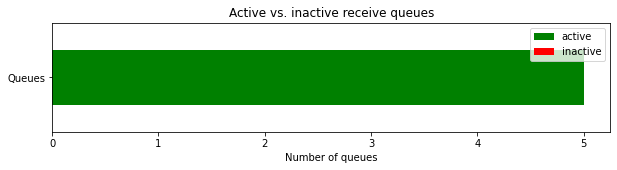

In [17]:
# The function get_apply_status executes a query which counts active vs. inactive queues
# and returns a pandas data frame
df_qstate = get_recvq_state(connection)  

df_qstate.set_index('queues',inplace=True)

# plotting a bar chart
qpl = df_qstate.plot.barh(stacked=True,color=['green', 'red'], 
                          title="Active vs. inactive receive queues",
                          figsize=(10,2))

qpl.set_xlabel("Number of queues")
myvar = qpl.set_ylabel("")

[Back to Top](#top)
<a id='qsubs_recvq'></a>

## Subscription STATE by receive queue

Number of active subscriptions (green) vs. number of inactive subscriptions (red) per receive queue

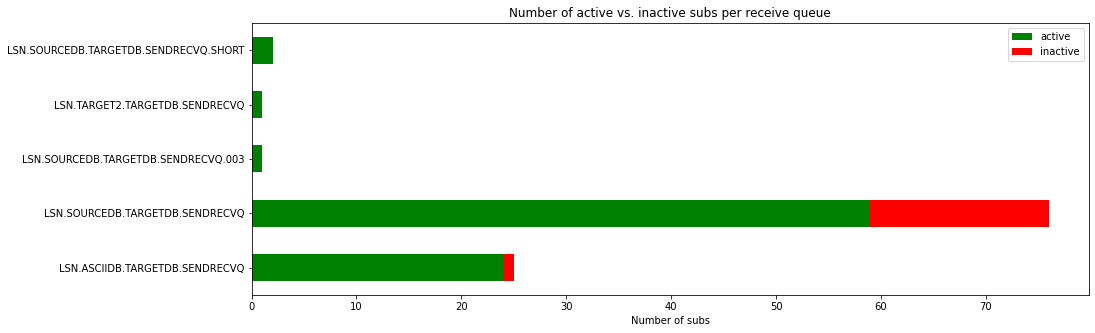

In [18]:
# The function get_substate_by_recvq executes a query which counts active vs. inactive queues
# and returns a pandas data frame
df_q = get_substate_by_recvq(connection)

# Determination of the number of distinct receive queues in the result set
numqs = len(df_q.recvq.unique())

# The hight of the following bar charts depends on the number of distinct receive queues.
# The more queues, the less space per individual queue (to limit the size of the plot)
if numqs >=20:
    calc_fig_height = numqs / 2
if numqs <=2:
    calc_fig_height = numqs * 2
else:
    calc_fig_height =  numqs

df_q.set_index('recvq',inplace=True) 

# plotting a bar chart
sqpl = df_q.plot.barh(stacked=True,color=['green', 'red'],
                       title="Number of active vs. inactive subs per receive queue",
                       figsize=(15,calc_fig_height))

sqpl.set_xlabel("Number of subs")
myvar = sqpl.set_ylabel("")

[Back to Top](#top)
<a id='qsubs_type'></a>

## Subscription TYPE Overview

Number of Q Subscription target types per Receive Queue

In [19]:
# The function get_subtype_by_recvq executes a query which counts available subscriptions 
# by type and returns a pandas data frame
df_st = get_subtype_by_recvq(connection)

# DEBUG - print sample data of the data frame retrieved from APPLYMON
if debug:
    print(df_st)

In [20]:
# Determination of the number of distinct receive queues in the result set
numqs = len(df_st.recvq.unique())

# The following plot prints a pie for each queue. Two queues in the same row (always fig with 2 columns)
# With anaconda 3 'round' does an closest even round. round(1.5)=2 and round(2.5)=2. Therefore useless here.
# figrows = round(numqs / 2)
# The number of rows is the rounded number of queues devided by 2.
figrows = int((numqs/2)+0.5)

print('INFO: Figure will have ' + str(numqs) + ' pie chart(s) in ' + str(figrows) + ' row(s) and ' 
                                + '2 columns')

INFO: Figure will have 5 pie chart(s) in 3 row(s) and 2 columns


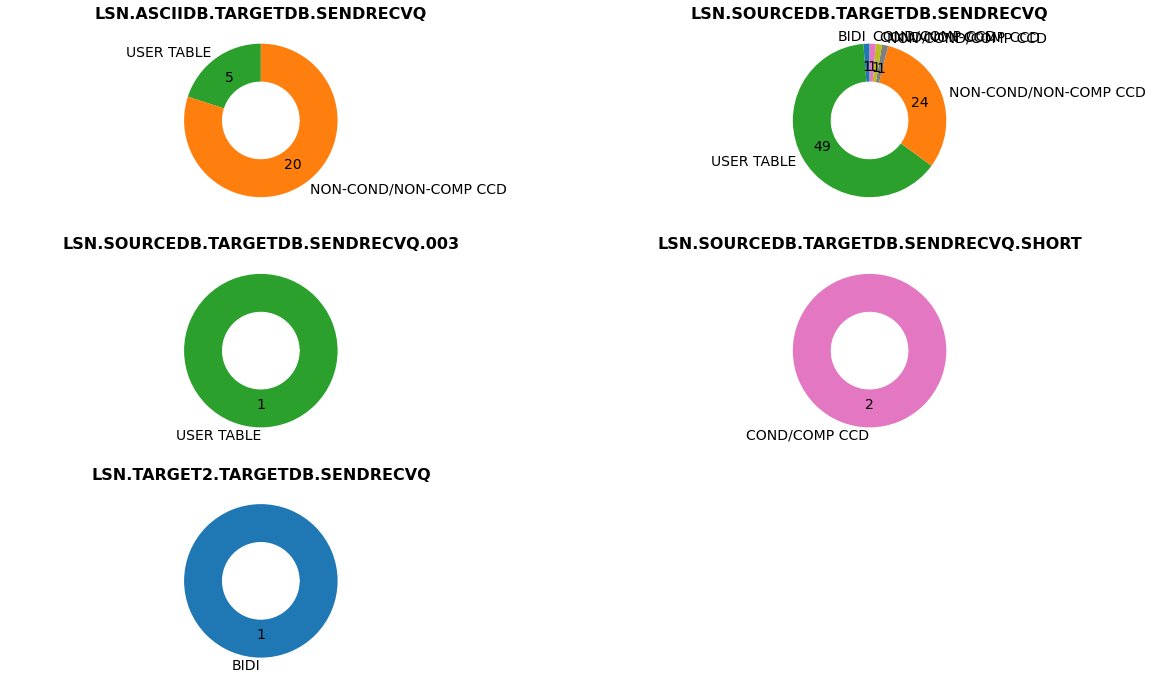

In [21]:
# The function plot_types creates a figure with n donut plots (n = number of queues) to display 
# the different subscription types per queue
subtypeplot = plot_types(df_st,numqs,figrows)
subtypeplot.show()

[Back to Top](#top)
<a id='qapp_performance_hour'></a>

# Q Apply Performance Graphs

## Apply throughput statistics per hour (rows_processed, latency, monster trans)

The following code creates plots which display Q Replication performance KPIs grouped by hour. First, <i>all</i> data available in IBMQREP_APPLYMON is evaluated (can be limited with parameter <i>max_mon_plot_range</i>). Next, the most recent 20 days will be evaluated, lastly the most recent 5 days. For each section (all, 20 days, 5 days) a separate plot is shown for each receive queue.<p>
The plots show the 
* max Capture, Q (Apply Browser), and Apply latency values seen in the particular hour
* the sum of all rows processed and rows applied for that hour
* the max queue depth seen in the particular hour

In [22]:
# The function get_perf_applymon executes a query which selects data from IBMQREP_APPLYMON
# and returns a pandas data frame. The APPLYMON data is GROUPed BY hour(monitor_time)
# by the query. In case max_mon_plot_range == -1, the query will retrieve all available data 
# from APPLYMON. If max_mon_plot_range > 0, the APPLYMON data will be limited to the recent
# max_mon_plot_range days

if max_mon_plot_range == -1:              
    print('INFO: Evaluating all available APPLYMON data') 
else:   
    print('INFO: Limiting the APPLYMON data to a maximum of ' + str(max_mon_plot_range) + ' days.')
              
applymon_lat = get_perf_applymon(connection, max_mon_plot_range)

INFO: Limiting the APPLYMON data to a maximum of 60 days.


In [23]:
# DEBUG - print sample data of the data frame retrieved from APPLYMON
if debug:
    print(applymon_lat)

In [24]:
# Determine the date of max(monitor_time). This is used when only a subset (e.g., most recent
# 5 days of data) is displayed later. Could be that the Notebook is used to evaluate saved 
# APPLYMON data, so that today() - n days would have no data. 
maxmontime = applymon_lat['monitor_date'].max()
maxmondate = datetime.strptime(maxmontime[:10], "%Y-%m-%d")

minmontime = applymon_lat['monitor_date'].min()
minmondate = datetime.strptime(minmontime[:10], "%Y-%m-%d")

if debug:
    print('DEBUG: minmondate.global=' + str(minmondate)[:10])
    print('DEBUG: maxmondate.global=' + str(maxmondate)[:10])
    print()

# Determination of the number of distinct receive queues in the result set
numqs = len(applymon_lat.recvq.unique())

print('INFO: Number of queues=' + str(numqs))

# print the distinct names and data ranges of the queues
for i in range(0,numqs):
    minmontimeq = applymon_lat[applymon_lat.recvq == applymon_lat.recvq.unique()[i]]['monitor_date'].min()
    maxmontimeq = applymon_lat[applymon_lat.recvq == applymon_lat.recvq.unique()[i]]['monitor_date'].max()
    minmondateq = datetime.strptime(minmontimeq[:10], "%Y-%m-%d")                
    maxmondateq = datetime.strptime(maxmontimeq[:10], "%Y-%m-%d")        
    print('INFO: ' + applymon_lat.recvq.unique()[i] + ' [' + str(minmondateq)[:10] + ' - ' 
                   + str(maxmondateq)[:10] + ']')

INFO: Number of queues=5
INFO: LSN.ASCIIDB.TARGETDB.SENDRECVQ [2021-09-07 - 2021-09-07]
INFO: LSN.SOURCEDB.TARGETDB.SENDRECVQ.003 [2021-09-07 - 2021-09-07]
INFO: LSN.SOURCEDB.TARGETDB.SENDRECVQ.SHORT [2021-09-07 - 2021-09-07]
INFO: LSN.TARGET2.TARGETDB.SENDRECVQ [2021-09-07 - 2021-09-07]
INFO: LSN.SOURCEDB.TARGETDB.SENDRECVQ [2021-09-07 - 2021-09-07]


All available data from IBMQREP_APPLYMON (max. <i>max_mon_plot_range</i> days)

INFO: Plotting range: Maximum of most recent 60 days between 2021-09-07 and 2021-09-07


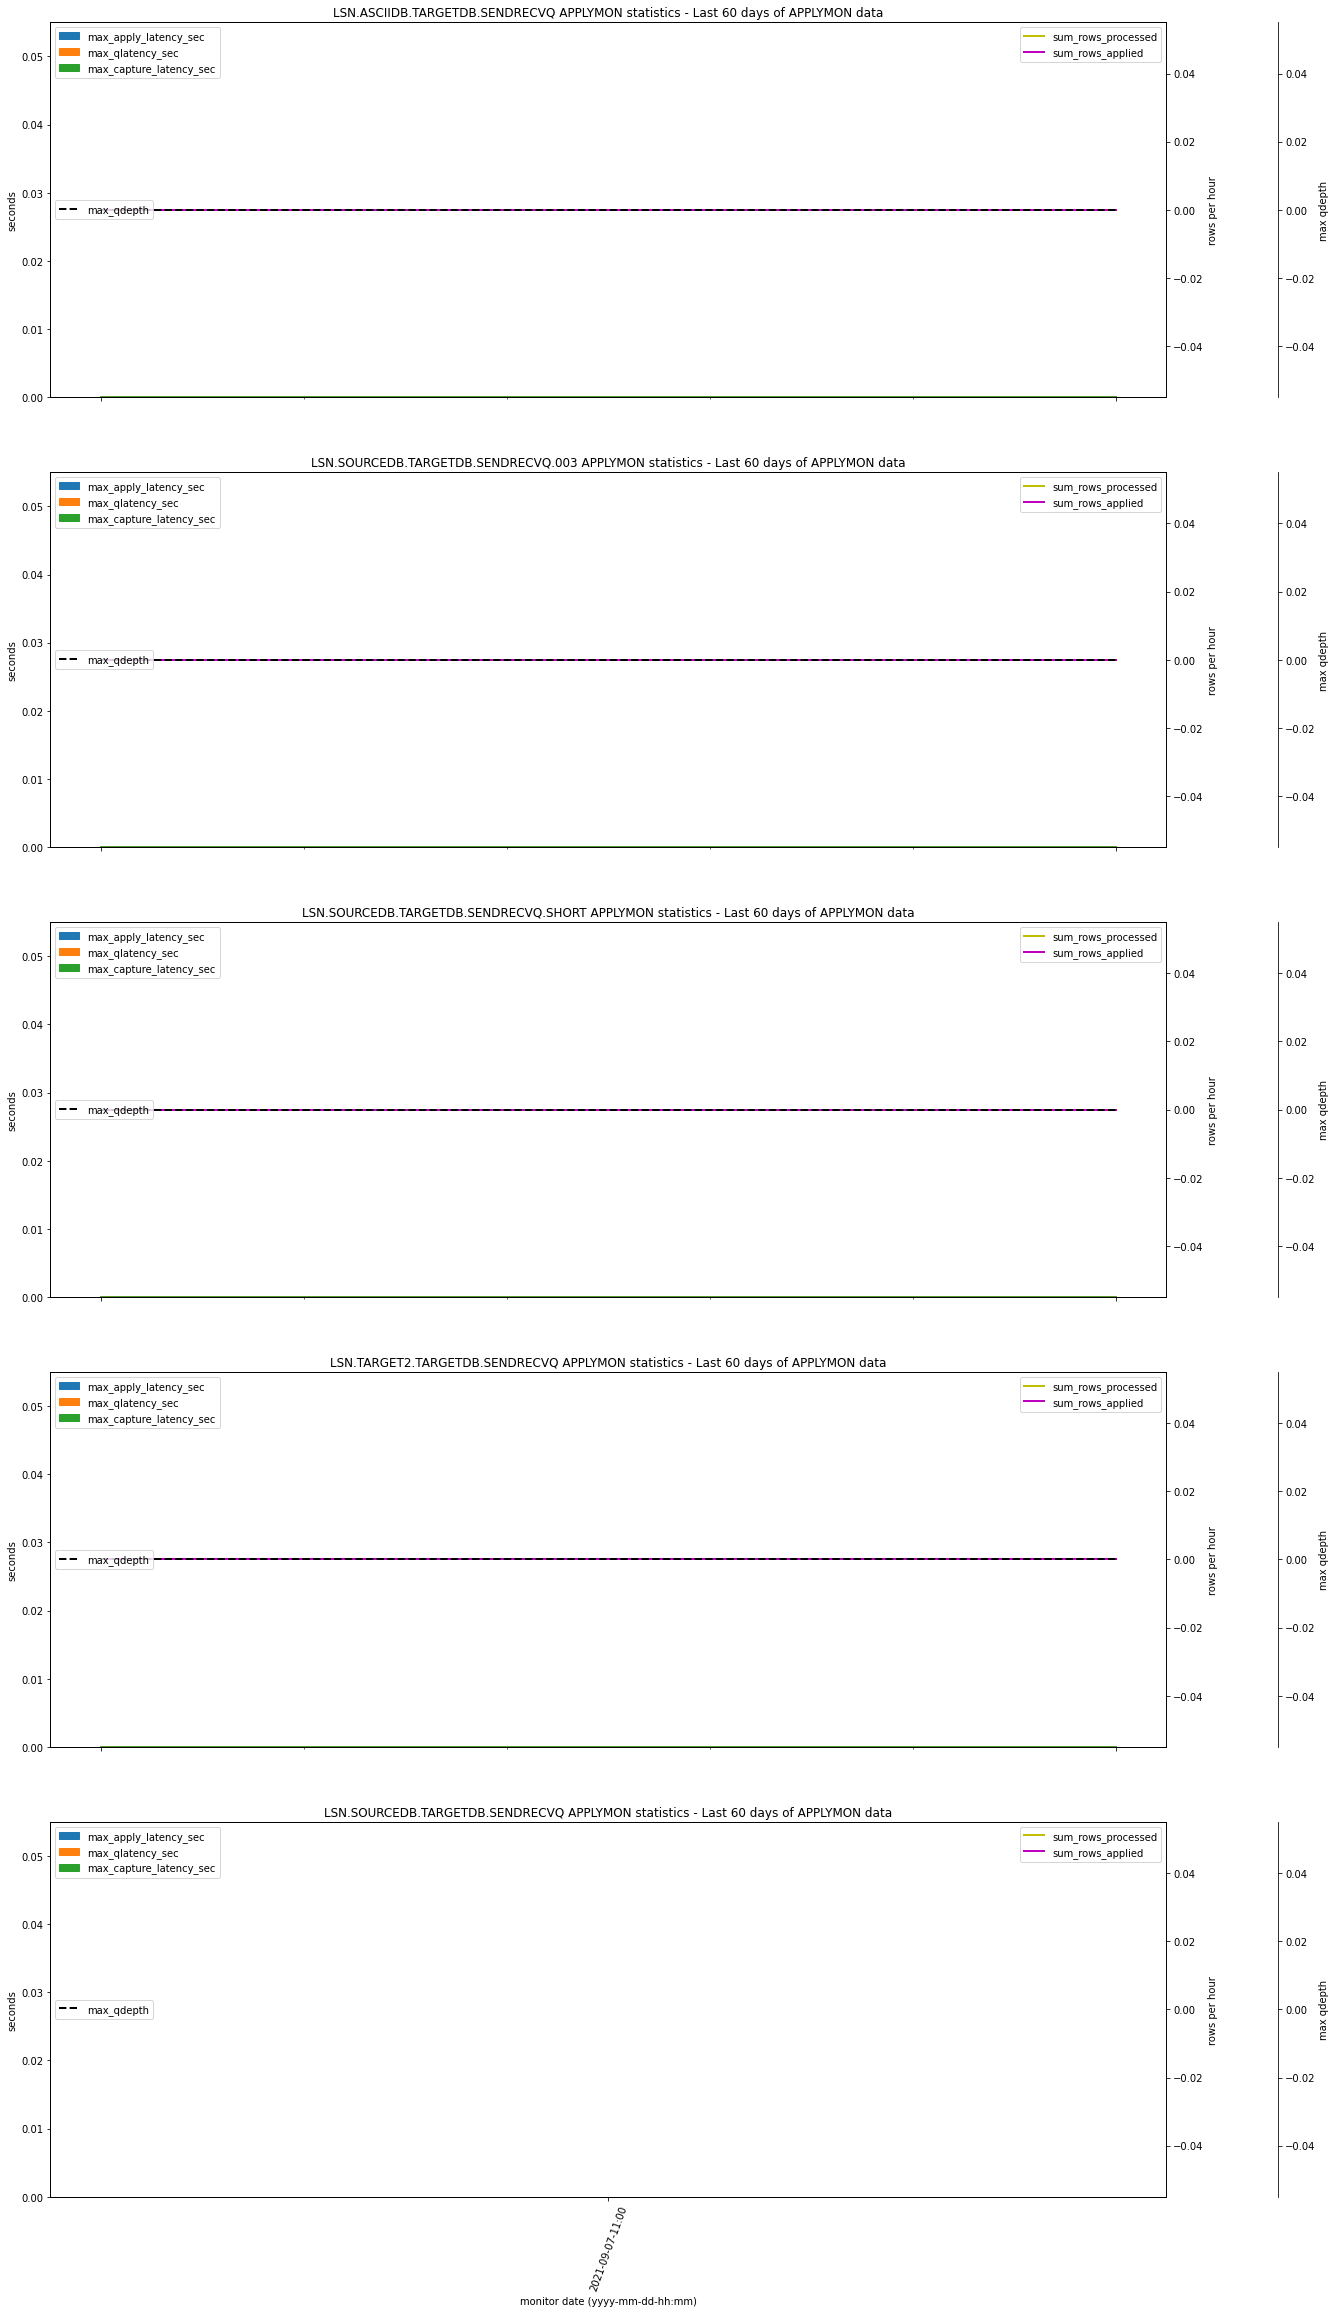

In [25]:
# Plot figure (one plot per queue) with all available data   

# deltadays = -1 means all available data of the data frame
deltadays = max_mon_plot_range
if deltadays == -1:
    date_max_days_ago = minmondate
else:
    date_max_days_ago = maxmondate - timedelta(days=deltadays)

# Debug
if debug:
    print('DEBUG: date_max_days_ago.strftime("%Y-%m-%d"): ' + date_max_days_ago.strftime("%Y-%m-%d"))        

if deltadays == -1:
    print('INFO: Plotting range: All available data from ' + minmondate.strftime("%Y-%m-%d") 
                                                           + ' up to ' + maxmondate.strftime("%Y-%m-%d"))
else:
    print('INFO: Plotting range: Maximum of most recent '  + str(deltadays) + ' days between ' 
                                                           + minmondate.strftime("%Y-%m-%d") + ' and ' 
                                                           + maxmondate.strftime("%Y-%m-%d"))

# The function plot_lat creates a figure with n plots (n = number of queues) from the 
# data frame applymon_lat
# The hight of the following figures (calculated in plot_lat) depends on the number of distinct 
# receive queues. The more queues, the less space per individual queue (to limit the size of the figure)
if numqs == 0:
    # Data frame could be empty
    print('WARNING: No data available to display.')
else:    
    applymon_plt60 = plot_lat(applymon_lat,numqs,deltadays,'by_hour')
    applymon_plt60.show()       

Recent 20 days from IBMQREP_APPLYMON

INFO: Plotting range: Maximum of most recent 20 days between 2021-09-07 and 2021-09-07


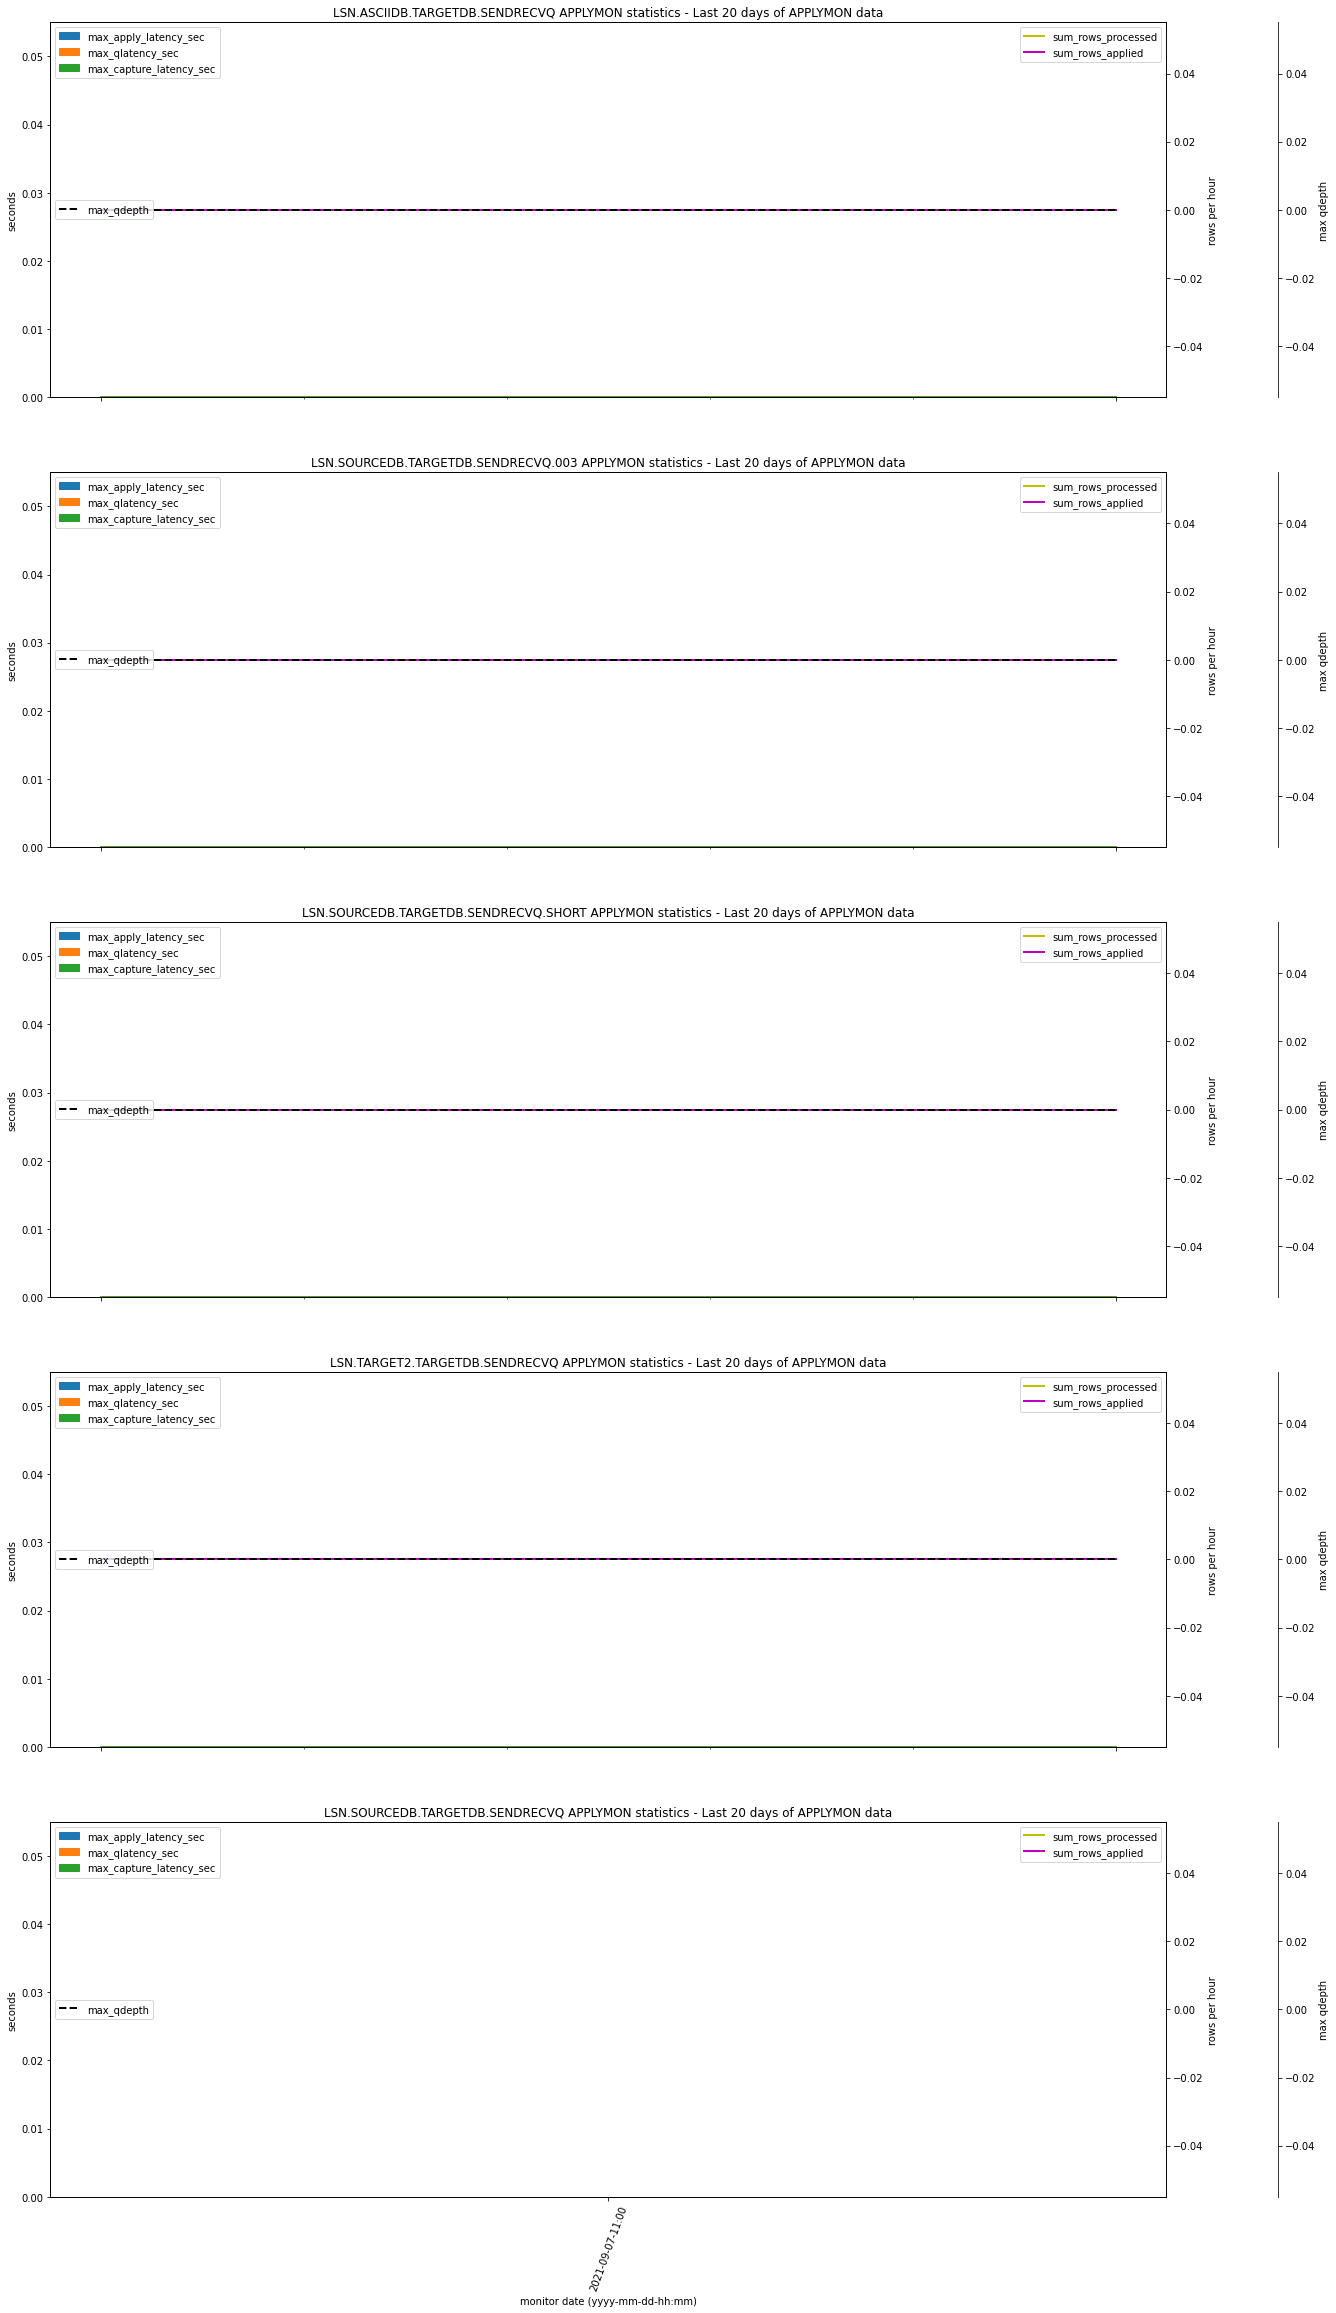

In [26]:
# Zoom in - Same figure as above, with data of the last 20 days only (maxmondate - 20 days)

# display 20 days of data only
deltadays = 20
# old: date_20_days_ago = date.today() - timedelta(days=deltadays)
date_20_days_ago = maxmondate - timedelta(days=deltadays)

# Debug
if debug:
   print('DEBUG: date_20_days_ago.strftime("%Y-%m-%d"): ' + date_20_days_ago.strftime("%Y-%m-%d"))

print('INFO: Plotting range: Maximum of most recent '  + str(deltadays) + ' days between ' 
                                                       + minmondate.strftime("%Y-%m-%d") + ' and ' 
                                                       + maxmondate.strftime("%Y-%m-%d"))
    
# New data frame - limited by the calculated data range
#   - reset_index was introduced to guarantee xticks in the plot
applymon_lat_20 = applymon_lat[applymon_lat.monitor_date 
                               >= date_20_days_ago.strftime("%Y-%m-%d")].reset_index(drop=True)

# The limited data could have a different number of queues
# calc_fig_height remains as calculated before
numqs = len(applymon_lat_20.recvq.unique())

if numqs == 0:
    # Data frame could be empty
    print('WARNING: No data available to display with MONITOR_TIME > ' + date_20_days_ago.strftime("%Y-%m-%d"))
else:
    applymon_plt20 = plot_lat(applymon_lat_20,numqs,deltadays,'by_hour')
    applymon_plt20.show()        

Recent 5 days from IBMQREP_APPLYMON

INFO: Plotting range: Maximum of most recent 5 days between 2021-09-07 and 2021-09-07


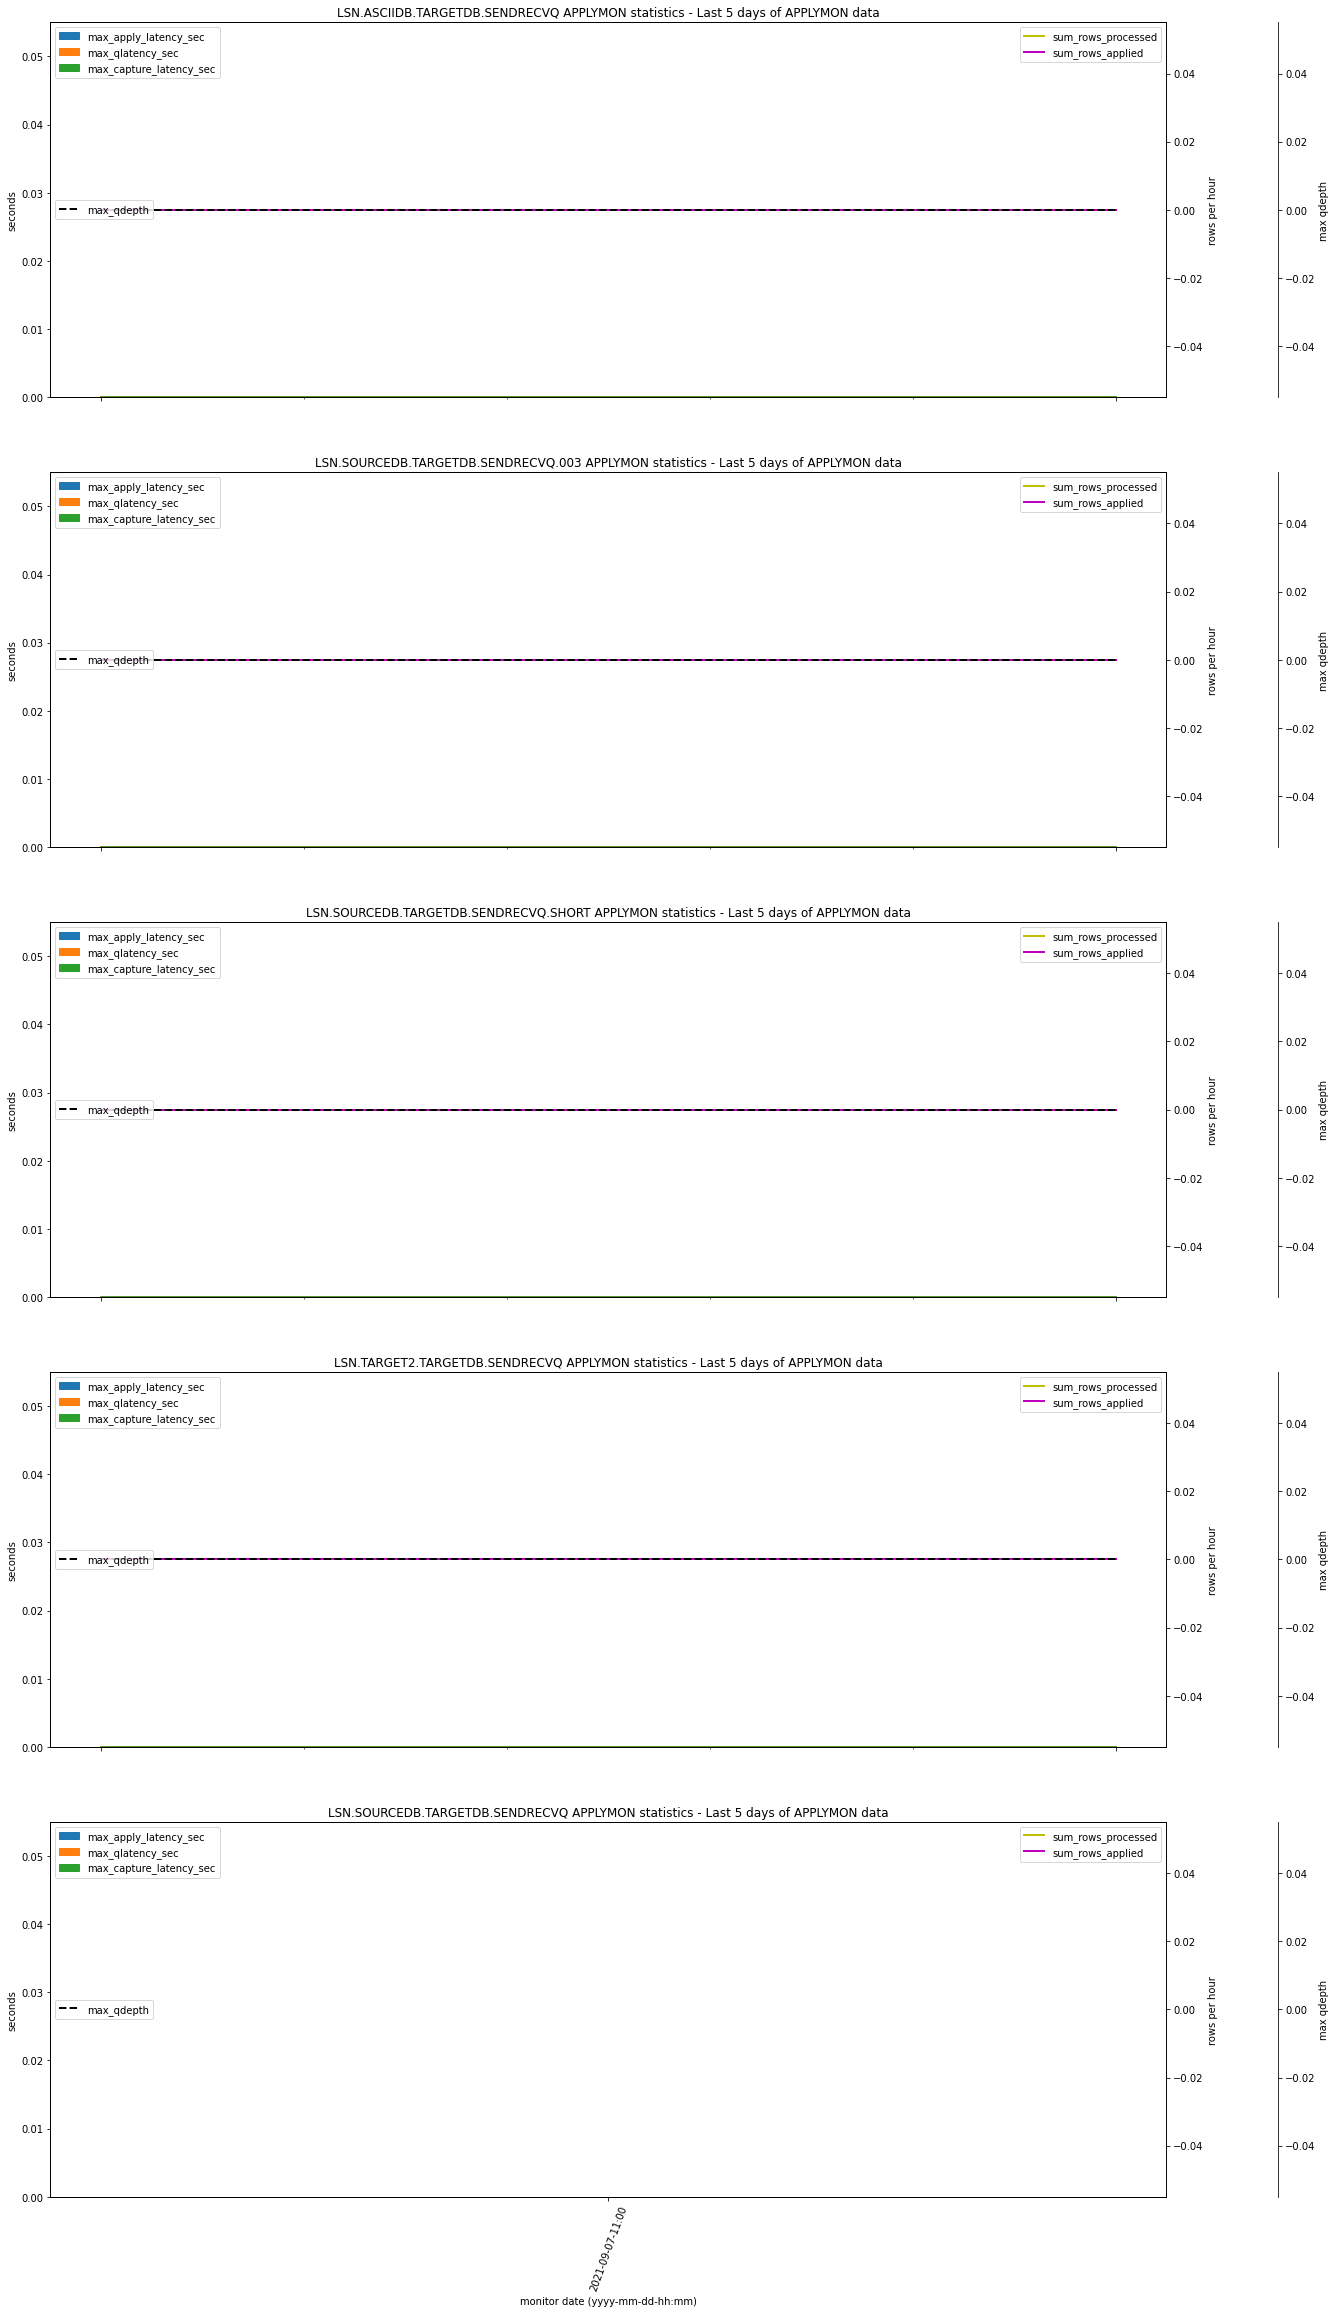

In [27]:
# Zoom in - Same figure as above, with data of the last 5 days only (maxmondate - 5 days)

# display 5 days of data only
deltadays = 5

# old: date_5_days_ago = date.today() - timedelta(days=deltadays)
date_5_days_ago = maxmondate - timedelta(days=deltadays)

# Debug
if debug:
    print('DEBUG: date_5_days_ago.strftime("%Y-%m-%d"): ' + date_5_days_ago.strftime("%Y-%m-%d"))

print('INFO: Plotting range: Maximum of most recent '  + str(deltadays) + ' days between ' 
                                                       + minmondate.strftime("%Y-%m-%d") + ' and ' 
                                                       + maxmondate.strftime("%Y-%m-%d"))

# New data frame - limited by the calculated data range 
#   - reset_index was introduced to guarantee xticks in the plot
applymon_lat_5 = applymon_lat[applymon_lat.monitor_date 
                              >= date_5_days_ago.strftime("%Y-%m-%d")].reset_index(drop=True)  

# The limited data could have a different number of queues
# calc_fig_height remains as calculated before
numqs = len(applymon_lat_5.recvq.unique())

if numqs == 0:
    # Data frame could be empty
    print('WARNING: No data available to display with MONITOR_TIME > ' + date_5_days_ago.strftime("%Y-%m-%d"))
else:    
    applymon_plt5 = plot_lat(applymon_lat_5,numqs,deltadays,'by_hour')
    applymon_plt5.show()    

[Back to Top](#top)
<a id='qapp_performance_day'></a>

## Apply throughput statistics per day - all available data from APPLYMON (rows_processed, latency)

The following code creates plots which display Q Replication performance KPIs grouped by day. All data available in IBMQREP_APPLYMON is evaluated. A separate plot is shown for each receive queue.<p>
The plots show 
* the max Capture, Q (Apply Browser), and Apply latency values for a day
* the sum of all rows processed and rows applied
* the max queue depth seen in the particular hour

In [28]:
# The function get_perf_applymon_day executes a query which selects data from IBMQREP_APPLYMON
# and returns a pandas data frame. The APPLYMON data is GROUPed BY day(monitor_time)
# by the query. The query will retrieve all available data from APPLYMON.

print('INFO: Evaluating all available APPLYMON data') 
              
applymon_lat_day = get_perf_applymon_day(connection)

INFO: Evaluating all available APPLYMON data


In [29]:
# DEBUG - print sample data of the data frame retrieved from APPLYMON
if debug:
   print(applymon_lat_day)

In [30]:
# Plot figure (one plot per queue) with all available data   

deltadays = -1

maxmontimed = applymon_lat_day['monitor_date'].max()
maxmondated = datetime.strptime(maxmontime[:10], "%Y-%m-%d")

minmontimed = applymon_lat_day['monitor_date'].min()
minmondated = datetime.strptime(minmontime[:10], "%Y-%m-%d")

# Determination of the number of distinct receive queues in the result set
numqs = len(applymon_lat_day.recvq.unique())

# DEBUG - print the number of queues and the distinct names of the queues
if debug:
    print('DEBUG: Number of queues=' + str(numqs))
    for i in range(0,numqs):
       print('DEBUG: ' + applymon_lat_day.recvq.unique()[i])

INFO: Plotting range: All available data from 2021-09-07 up to 2021-09-07


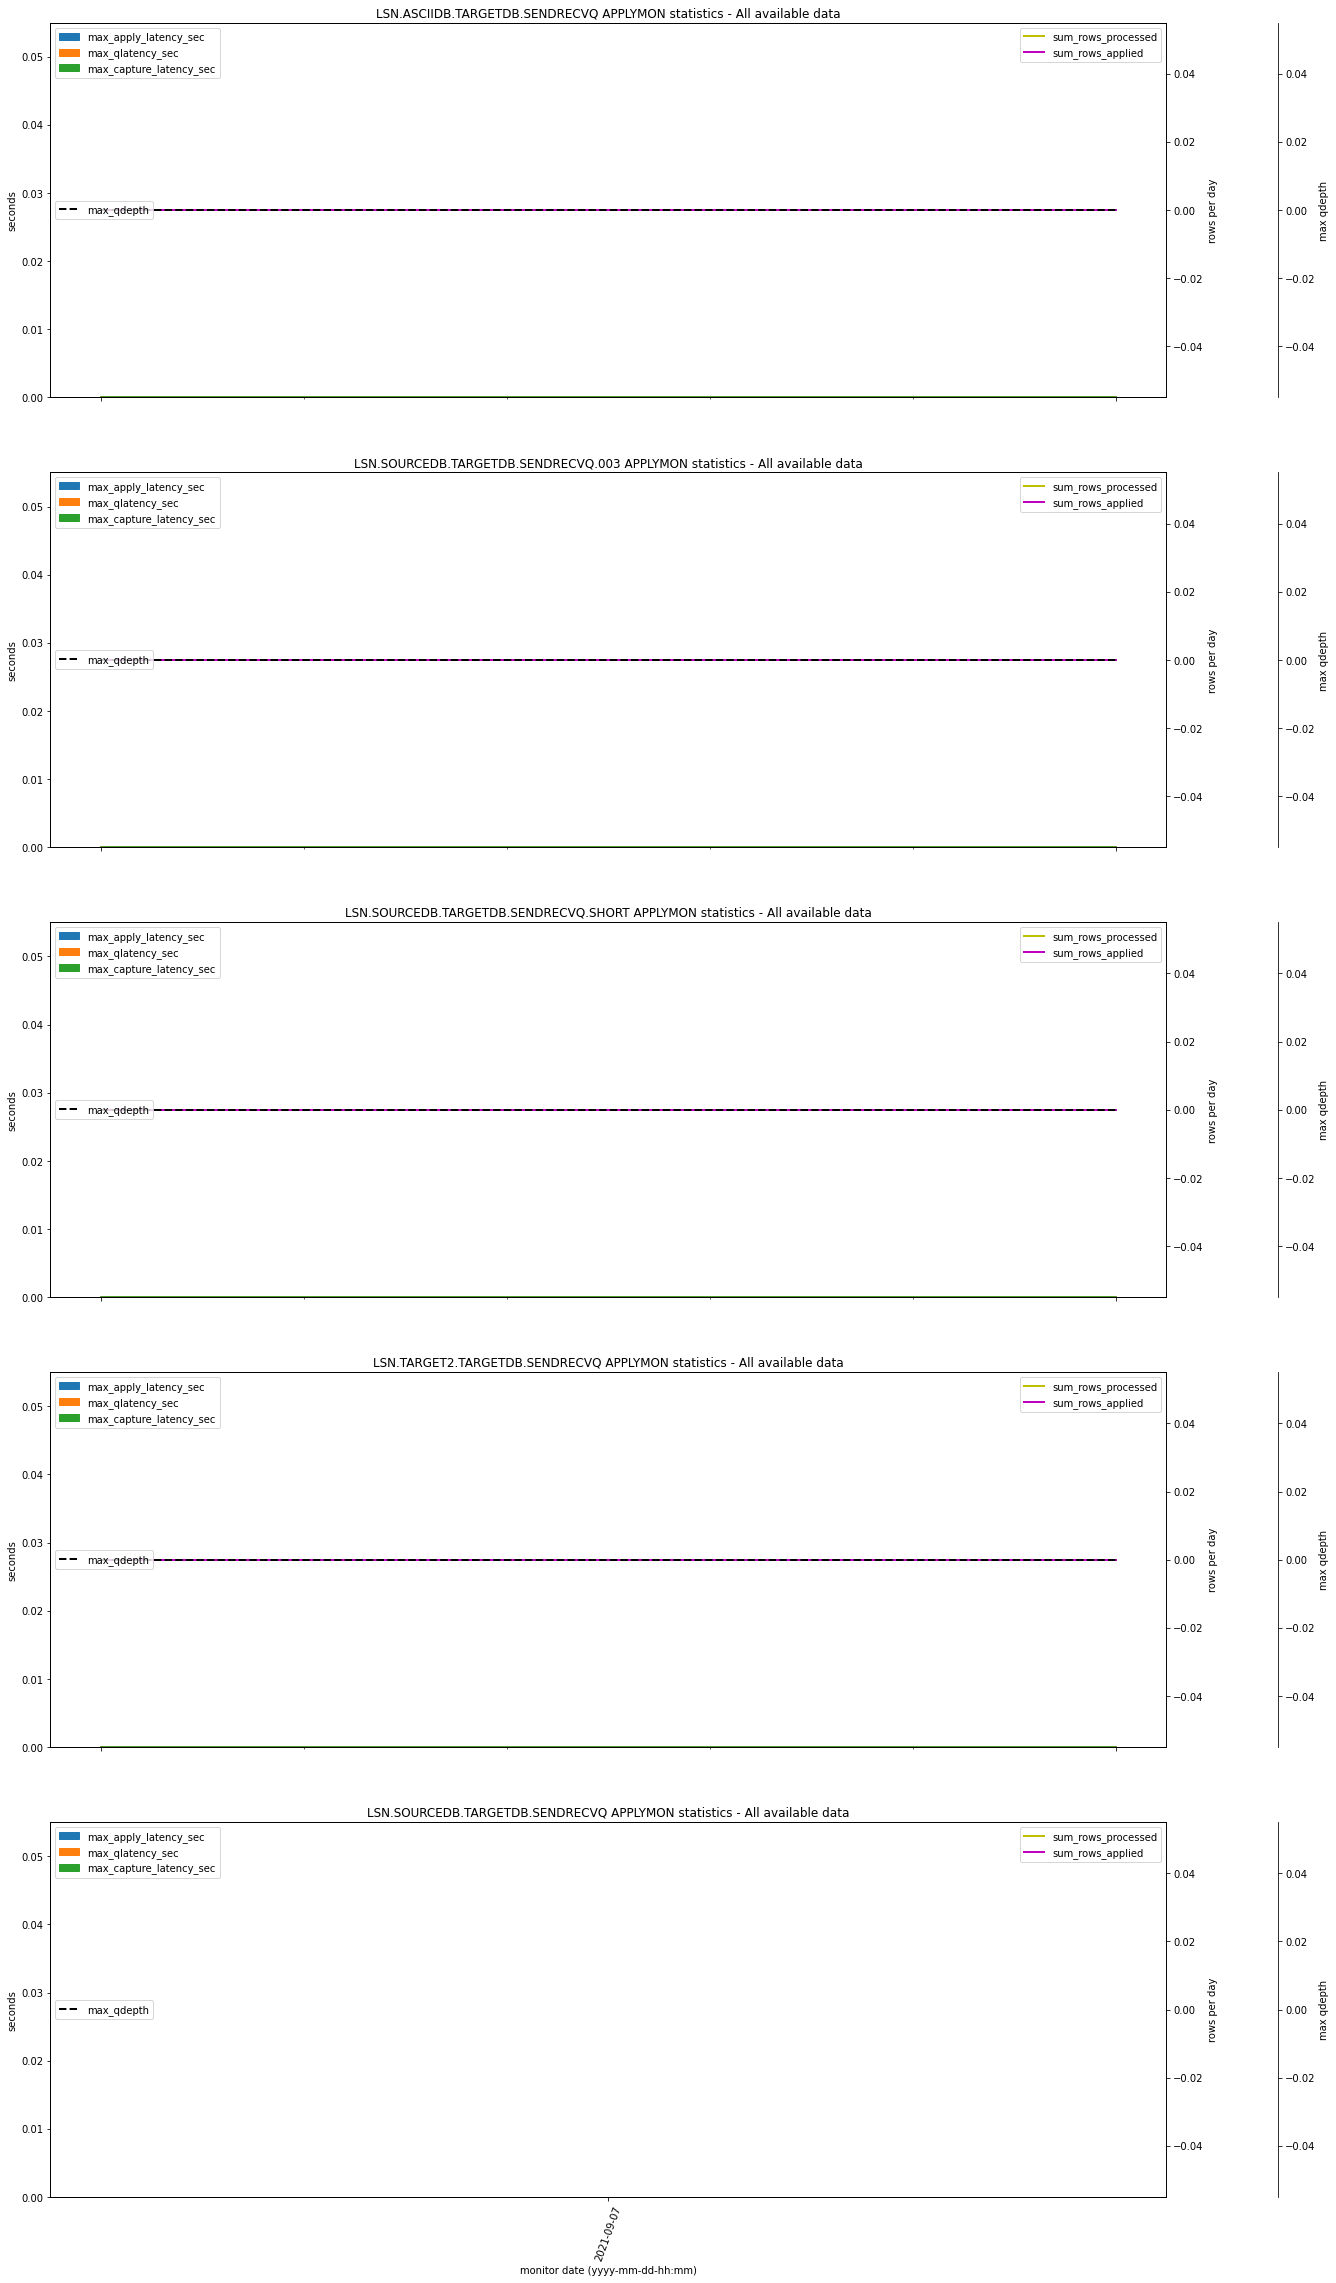

In [31]:
print('INFO: Plotting range: All available data from ' + minmondated.strftime("%Y-%m-%d") 
                                                           + ' up to ' + maxmondated.strftime("%Y-%m-%d"))

# The function plot_lat creates a figure with n plots (n = number of queues) from the 
# data frame applymon_lat
# The hight of the following figures (calculated in plot_lat) depends on the number of distinct 
# receive queues. The more queues, the less space per individual queue (to limit the size of the figure)
if numqs == 0:
    # Data frame could be empty
    print('No data available to display')
else:    
    applymon_plt_day = plot_lat(applymon_lat_day,numqs,deltadays,'by_day')
    applymon_plt_day.show() 

[Back to Top](#top)
<a id='qapp_performance_details'></a>

## Detailed Apply throughput statistics (APPLYMON) - one hour of available data

The following code creates plots which display Q Replication performance detail KPIs for one hour of APPLYMON data. A separate plot is shown for each receive queue. The start timestamp (start_ts_mon_plot_details) can be set in the parameters section at the top of this notebook.

In [32]:
# The function get_perf_applymon_detail executes a query which selects data from IBMQREP_APPLYMON
# and returns a pandas data frame. The query will retrieve one hour of data from APPLYMON, starting 
# at start_ts_mon_plot_details (defined in the defaults section of this Notebook). If 
# start_ts_mon_plot_details == 'max', the last hour of available data will be analyzed

print('INFO: Evaluating APPLYMON details starting from ' + start_ts_mon_plot_details)

applymon_details = get_perf_applymon_detail(connection, start_ts_mon_plot_details)
mi = get_monitor_interval(connection)

INFO: Evaluating APPLYMON details starting from max


In [33]:
# DEBUG - print sample data of the data frame retrieved from APPLYMON
if debug:
   print(applymon_details)

In [34]:
# Determination of the number of distinct receive queues in the result set
numqs = len(applymon_details.recvq.unique())

print('INFO: Number of queues=' + str(numqs))

# DEBUG - print the number of queues and the distinct names of the queues
if debug:
    for i in range(0,numqs):
       print('DEBUG: ' + applymon_details.recvq.unique()[i])

INFO: Number of queues=5


INFO: MONITOR_INTERVAL=10000 milliseconds (10.0 seconds)


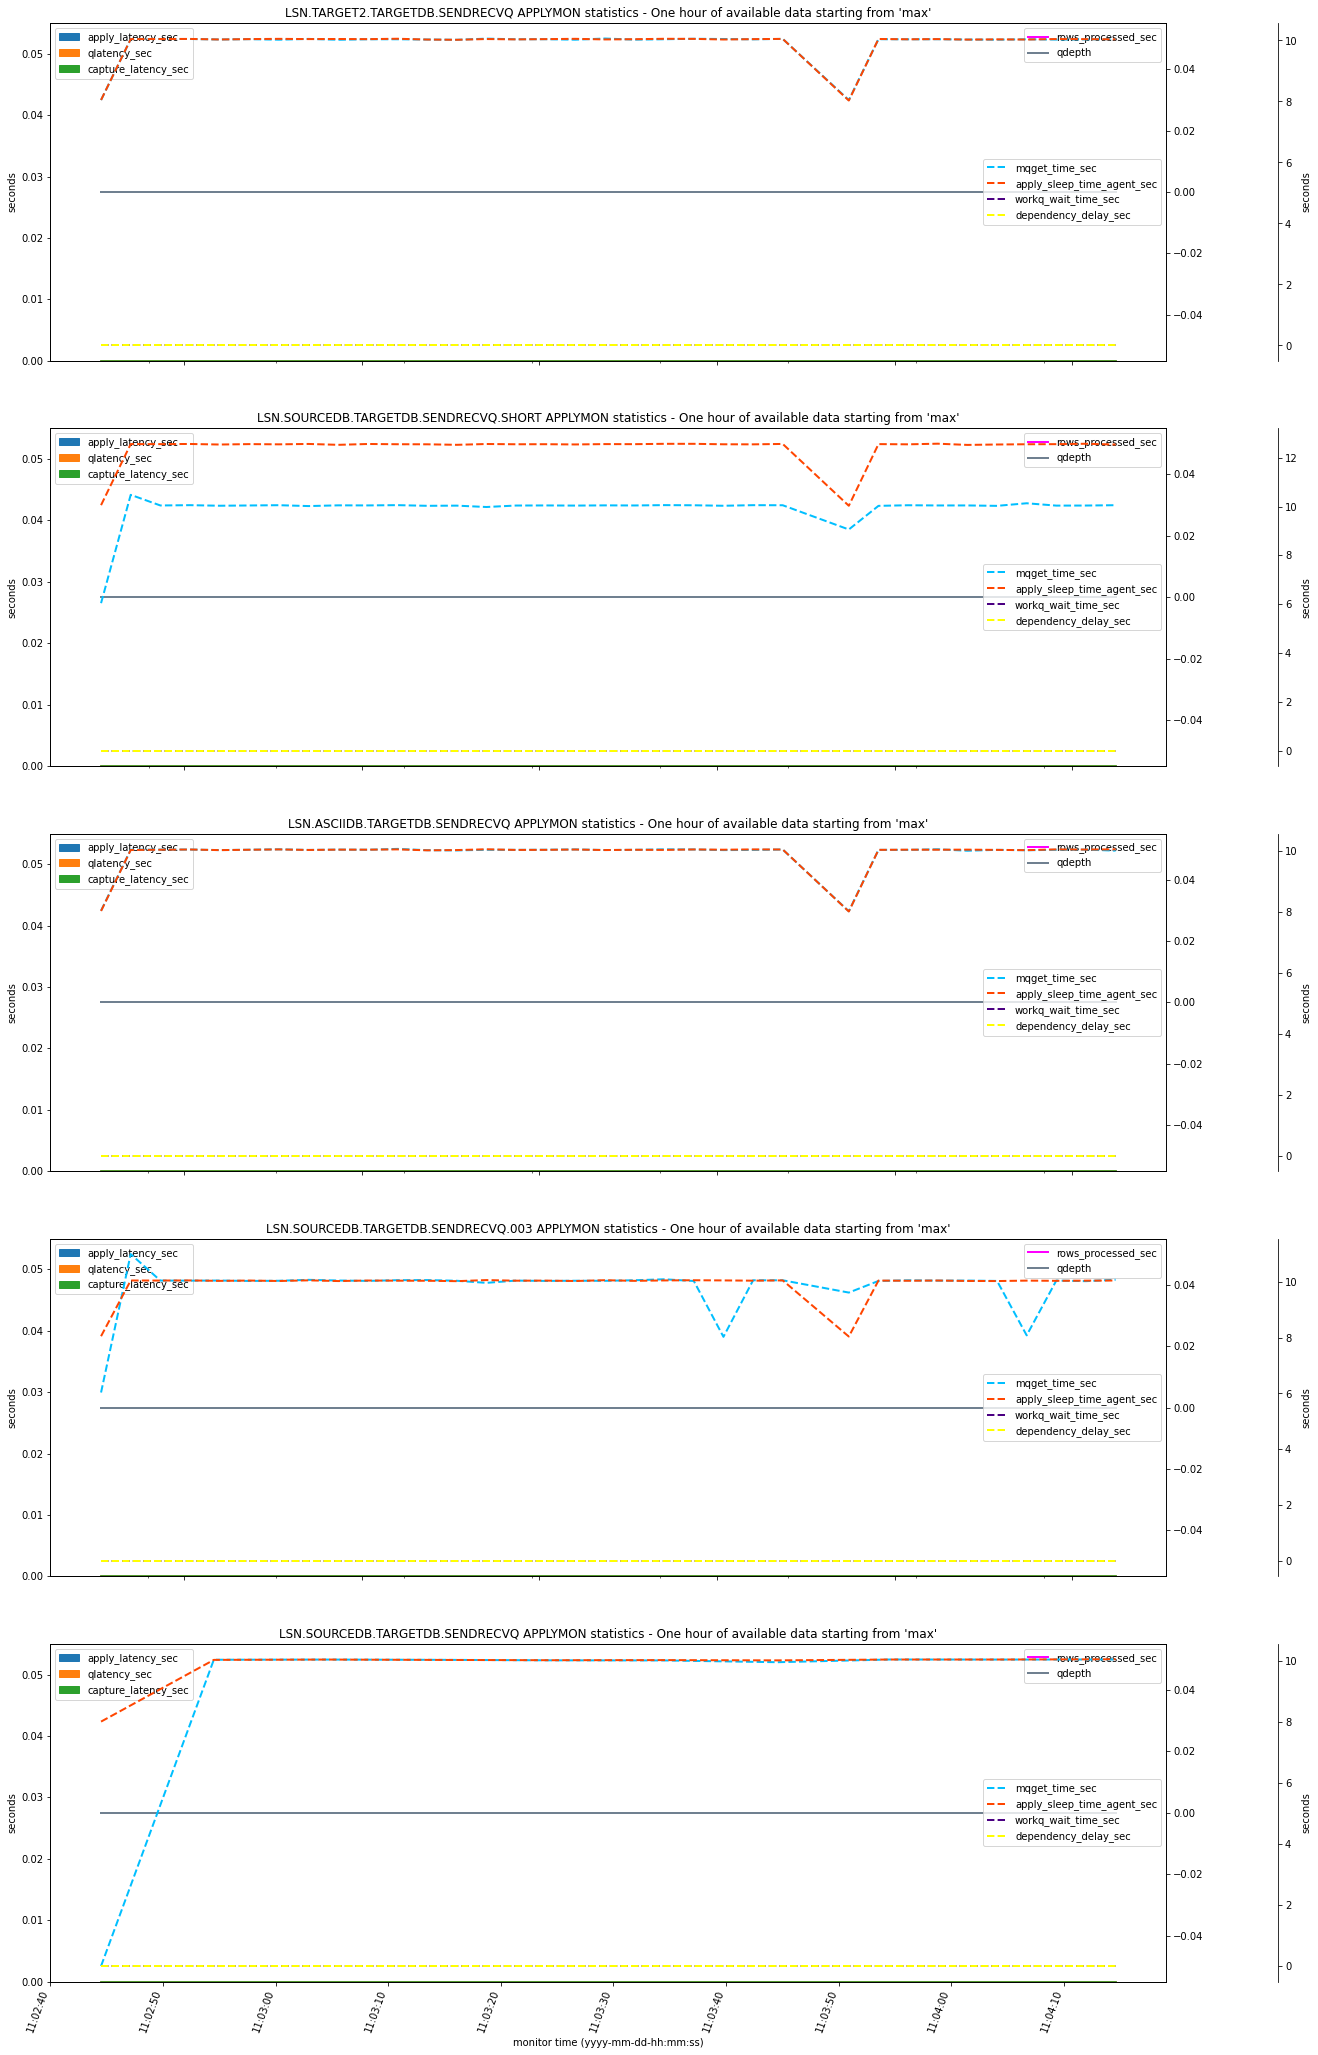

In [35]:
# Plot figure (one plot per queue), 1 hour of data
print('INFO: MONITOR_INTERVAL=' + str(mi) + ' milliseconds (' + str(mi/1000) + ' seconds)')

# The function plot_lat_details creates a figure with n plots (n = number of queues) from the 
# data frame applymon_details
# The hight of the following figures (calculated in plot_lat_details) depends on the number of distinct 
# receive queues. The more queues, the less space per individual queue (to limit the size of the figure)
if numqs == 0:
    # Data frame could be empty
    print('INFO: No data available to display with MONITOR_TIME > ' + start_ts_mon_plot_details)
else:    
    applymon_plt_details = plot_lat_details(applymon_details,numqs,start_ts_mon_plot_details,'by_interval')
    applymon_plt_details.show()

[Back to Top](#top)
<a id='qapp_details'></a>

# Q Apply details

## Receive Queue details

Receive queue details (IBMQREP_RECVQUEUES)

In [36]:
# The function get_recvq_details executes a query which selects detail data from IBMQREP_RECVQUEUES
# and returns a pandas data frame
df_queues = get_recvq_details(connection, apply_schema)

df_queues.set_index(['sendq'],inplace=True)
df_queues.sort_values(['sendq'], ascending=[True], inplace=True)

# printing the data frame
df_queues

,repqmapname,recvq,adminq,num_apply_agents,memory_limit,capture_server,capture_alias,capture_schema,state,state_time,state_info,description,source_type,maxagents_correlid,rollback_r_report,browser_thread_id,parallel_sendqs,mcgname,agent_stmt_cache_sz,mri_memory_limit,bidiapply_schema,has_filerecv,num_stream_agents,capture_level
sendq,,,,,,,,,,,,,,,,,,,,,,,,
LSN.ASCIIDB.TARGETDB.SENDRECVQ,ASCIIDB_LSN_TO_TARGETDB_LSN,LSN.ASCIIDB.TARGETDB.SENDRECVQ,LSN.ASCIIDB.ADMINQ,6,64,ASCIIDB,ASCIIDB,LSN,A,2021-09-07 11:02:34.453,ASN7526I,,D,0.0,R,None,N,None,300,1024,None,N,0,1140.106
LSN.SOURCEDB.TARGETDB.SENDRECVQ,SOURCEDB_LSN_TO_TARGETDB_LSN,LSN.SOURCEDB.TARGETDB.SENDRECVQ,LSN.SOURCEDB.ADMINQ,6,16,SOURCEDB,SOURCEDB,LSN,A,2021-09-07 11:02:34.453,ASN7526I,None,D,NaN,R,None,N,None,300,1024,None,N,0,1140.106
LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,XXX,LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,LSN.SOURCEDB.ADMINQ,6,16,SOURCEDB,SOURCEDB,LSN,A,2021-09-07 11:02:34.454,ASN7526I,None,D,NaN,R,None,N,None,300,1024,None,N,0,1140.106
LSN.SOURCEDB.TARGETDB.SENDRECVQ.SHORT,SOURCEDB_LSN_TO_TARGETDB_LSN_SHORT,LSN.SOURCEDB.TARGETDB.SENDRECVQ.SHORT,LSN.SOURCEDB.ADMINQ,4,64,SOURCEDB,SOURCEDB,LSN,A,2021-09-07 11:02:34.454,ASN7526I,,D,0.0,R,None,N,None,300,1024,None,N,1,1140.106
LSN.TARGET2.TARGETDB.SENDRECVQ,TARGET2_LSN_TO_TARGETDB_LSN,LSN.TARGET2.TARGETDB.SENDRECVQ,LSN.TARGET2.ADMINQ,6,64,TARGET2,TARGET2,LSN,A,2021-09-07 11:02:34.454,ASN7526I,,D,0.0,R,None,N,None,300,1024,None,N,0,1140.106


[Back to Top](#top)
<a id='qsubs_details'></a>

## Subscription details

Subscription details (IBMQREP_TARGETS). Use pixiedust options to filter the result set or to convert the table into a  graph.

In [ ]:
# The function get_targets_details executes a query which selects detail data from IBMQREP_TARGETS
# and returns a pandas data frame
df_subs = get_targets_details(connection, apply_schema)

df_subs.sort_values(['subname'], ascending=[True], inplace=True)    

# displaying the data frame using pixiedust
display(df_subs)

subname,recvq,sub_id,source_server,source_alias,source_owner,source_name,src_nickname_owner,src_nickname,target_owner,target_name,target_type,federated_tgt_srvr,state,state_time,state_info,subtype,conflict_rule,conflict_action,error_action,spillq,oksqlstates,subgroup,source_node,target_node,group_init_role,has_loadphase,load_type,description,search_condition,modelq,ccd_condensed,ccd_complete,source_type,schema_subname,sub_creator,repl_drop_col,repl_rename_col,repl_alter_col,src_location_alias,codepage_expand_factor,ccd_keyupd_as_delins,has_parts,source_is_columnar,load_createtab_remotesource
SHRINK_MEMFULL_T1,LSN.SOURCEDB.TARGETDB.SENDRECVQ,105.0,SOURCEDB,SOURCEDB,DE094692,SHRINK_MEMFULL_T1,None,None,DE094692,SHRINK_MEMFULL_T1,1,None,A,2021-03-30 09:17:57.798000,ASN7606I,U,K,I,Q,IBMQREP.SPILL.MODELQ.3.105.1,None,None,0,0,None,I,0,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N,N,N,0
S308_SIHT_SIRE,LSN.ASCIIDB.TARGETDB.SENDRECVQ,24.0,ASCIIDB,ASCIIDB,S308,SIHT_SIRE,None,None,S308,SIHT_SIRE_CCD,2,None,A,2020-02-05 11:15:20.417000,ASN7606I,U,K,F,D,None,None,None,0,0,None,N,0,None,None,IBMQREP.SPILL.MODELQ,N,N,D,None,asnclp,Y,Y,Y,None,1,N,N,N,0
ACCOUNT_BITEMP_SOURCE_STT_2_NSTT,LSN.SOURCEDB.TARGETDB.SENDRECVQ,86.0,SOURCEDB,SOURCEDB,BANK,ACCOUNT_BITEMP_SOURCE,None,None,BANK,ACCOUNT_BITEMP_TARGET,1,None,A,2020-09-03 12:00:04.123000,ASN7606I,U,K,I,D,IBMQREP.SPILL.MODELQ.3.86.1,None,None,0,0,None,I,1,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N,N,N,0
PARENT_02,LSN.SOURCEDB.TARGETDB.SENDRECVQ,47.0,SOURCEDB,SOURCEDB,DE094692,PARENT_02,None,None,DE094692,PARENT_02,1,None,A,2020-09-03 12:00:03.137000,ASN7606I,U,K,I,D,IBMQREP.SPILL.MODELQ.3.47.1,None,None,0,0,None,I,0,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N,N,N,0
KONTO_STT_HISTORY0001,LSN.SOURCEDB.TARGETDB.SENDRECVQ,32.0,SOURCEDB,SOURCEDB,BANK,KONTO_STT_HISTORY,None,None,BANK,KONTO_STT_HISTORY,1,None,A,2020-09-03 11:59:57.835000,ASN7606I,U,K,I,Q,None,None,None,0,0,None,N,0,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,None,Y,Y,Y,None,1,N,N,N,0
LONGCOL0001,LSN.SOURCEDB.TARGETDB.SENDRECVQ,33.0,SOURCEDB,SOURCEDB,DE094692,LONGCOL,None,None,DE094692,LONGCOL,2,None,A,2020-09-03 12:00:00.665000,ASN7606I,U,K,F,Q,None,None,None,0,0,None,N,0,None,None,IBMQREP.SPILL.MODELQ,N,N,D,None,None,Y,Y,Y,None,1,N,N,N,0
PARENT_01,LSN.SOURCEDB.TARGETDB.SENDRECVQ,45.0,SOURCEDB,SOURCEDB,DE094692,PARENT_01,None,None,DE094692,PARENT_01,1,None,A,2020-09-03 12:00:07.254000,ASN7606I,U,K,I,D,IBMQREP.SPILL.MODELQ.3.45.1,None,None,0,0,None,I,0,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N,N,N,0
IH0002,LSN.SOURCEDB.TARGETDB.SENDRECVQ,49.0,SOURCEDB,SOURCEDB,DE094692,IH,None,None,DE094692,IH_CCD,2,None,A,2020-09-03 12:00:01.085000,ASN7606I,U,K,F,Q,None,None,None,0,0,None,N,0,None,None,IBMQREP.SPILL.MODELQ,N,N,D,None,asnclp,Y,Y,Y,None,1,N,N,N,0
CODEPAGE_EXPAND_FACTOR_11144_UCOPY,LSN.ASCIIDB.TARGETDB.SENDRECVQ,20.0,ASCIIDB,ASCIIDB,DE094692,CODEPAGE_EXPAND_FACTOR_11144,None,None,DE094692,CODEPAGE_EXPAND_FACTOR_11144_UCOPY,1,None,A,2019-02-07 13:57:52.196000,ASN7606I,U,K,I,Q,None,None,None,0,0,None,I,0,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,2,N,N,N,0
PARENT1,LSN.SOURCEDB.TARGETDB.SENDRECVQ,57.0,SOURCEDB,SOURCEDB,DE094692,PARENT1,None,None,DE094692,PARENT1,1,None,A,2020-09-03 12:00:03.129000,ASN7606I,U,K,I,D,IBMQREP.SPILL.MODELQ.3.57.1,None,None,0,0,None,I,1,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N,N,N,0


[Back to Top](#top)
<a id='qsubs_qa'></a>

## Subscription quality assurance

Runtime error prevention for existing subscriptions. The following potential error situations are reported:
 <ul>
  <li>A-TNF - Target table not found</li>
  <li>A-CNF - Subscribed column does not exist in DB2</li>
  <li>A-CNS - Existing target column not subscribed</li>
  <li>A-GRA - Target table grant missing for Apply user</li>
  <li>A-RIP - Sub for RI parent of a replicated RI child missing</li>
  <li>A-RIC - Sub for RI child of a replicated RI parent missing</li>
  <li>A-BID - Before image column has different data type than after image column</li>
</ul> 

In [38]:
# The function get_apply_anomylies executes the query 'qrep_check_subs_apply.sql' 
# (with language dependent result set) and returns a pandas data frame
df_appqa = get_apply_anomylies(connection)

df_appqa.drop(df_appqa.columns[2], axis=1, inplace=True)

# conditional formatting for column 'sev'
df_appqa = (df_appqa.style
    .applymap(sev_background, subset=['sev'])
    .applymap(sev_foreground, subset=['sev'])
)

# printing the data frame
df_appqa

,check_ts,PROGRAM,mtyp,sev,mtxt,fixit
0,2021-09-07 11:04:42.070000,ASNQAPP(LSN),A-TNF,WARNING,"QSUB KONTO_0001 (I) for target table BANK.KONTO, STATE=I, exists, but the table does not exist in DB2! Remove the subscription.","DROP QSUB ( SUBNAME ""KONTO_0001"" USING REPLQMAP SOURCEDB_LSN_TO_TARGETDB_LSN);"
1,2021-09-07 11:04:42.070000,ASNQAPP(LSN),A-CNF,ERROR,QSUB ASN7099E_2 (I) contains target column DE094692.ASN7099E_2.NEWCOL_21 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.ASN7099E_2 ADD COLUMN NEWCOL_21
2,2021-09-07 11:04:42.070000,ASNQAPP(LSN),A-CNF,ERROR,QSUB ASN7099E_2 (I) contains target column DE094692.ASN7099E_2.NEWCOL_22 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.ASN7099E_2 ADD COLUMN NEWCOL_22
3,2021-09-07 11:04:42.070000,ASNQAPP(LSN),A-CNF,ERROR,QSUB ASN7099E_2 (I) contains target column DE094692.ASN7099E_2.NEWCOL_23 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.ASN7099E_2 ADD COLUMN NEWCOL_23
4,2021-09-07 11:04:42.070000,ASNQAPP(LSN),A-CNF,ERROR,QSUB ASN7099E_2 (I) contains target column DE094692.ASN7099E_2.NEWCOL_24 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.ASN7099E_2 ADD COLUMN NEWCOL_24
5,2021-09-07 11:04:42.070000,ASNQAPP(LSN),A-CNF,ERROR,QSUB ASN7099E_2 (I) contains target column DE094692.ASN7099E_2.NEWCOL_25 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.ASN7099E_2 ADD COLUMN NEWCOL_25
6,2021-09-07 11:04:42.070000,ASNQAPP(LSN),A-CNS,ERROR,QSUB ALTER_CHAR_VARCHAR (A) does not contain target col DE094692.ALTER_CHAR_VARCHAR.VARCHARCOL_2. Modify the subscription.,"Source ADDCOL SIGNAL, siehe qrep_check_qsubs_capture.sql oder BEF_TARG_COLNAME definieren"
7,2021-09-07 11:04:42.070000,ASNQAPP(LSN),A-CNS,ERROR,QSUB ASN7099E_1 (A) does not contain target col DE094692.ASN7099E_1.NEWCOL_31. Modify the subscription.,"Source ADDCOL SIGNAL, siehe qrep_check_qsubs_capture.sql oder BEF_TARG_COLNAME definieren"
8,2021-09-07 11:04:42.070000,ASNQAPP(LSN),A-CNS,ERROR,QSUB ASN7099E_1 (A) does not contain target col DE094692.ASN7099E_1.NEWCOL_32. Modify the subscription.,"Source ADDCOL SIGNAL, siehe qrep_check_qsubs_capture.sql oder BEF_TARG_COLNAME definieren"
9,2021-09-07 11:04:42.070000,ASNQAPP(LSN),A-CNS,ERROR,QSUB ASN7099E_1 (A) does not contain target col DE094692.ASN7099E_1.NEWCOL_33. Modify the subscription.,"Source ADDCOL SIGNAL, siehe qrep_check_qsubs_capture.sql oder BEF_TARG_COLNAME definieren"


[Back to Top](#top)
<a id='qapp_cntl'></a>

# Q Apply Control Tables

## Q Apply parameters

Stored Q Apply parameters (IBMQREP_APPLYPARMS)

In [39]:
# The function get_applyparms executes a query which selects detail data from IBMQREP_APPLYPARMS
# and returns a pandas data frame
df_applyparms = get_applyparms(connection, apply_schema)

# printing the data frame
df_applyparms

,qmgr,monitor_limit,trace_limit,monitor_interval,prune_interval,autostop,logreuse,logstdout,apply_path,arch_level,term,pwdfile,deadlock_retries,sql_cap_schema,loadcopy_path,nickname_commit_ct,spill_commit_count,load_data_buff_sz,classic_load_fl_sz,max_parallel_loads,commit_count,insert_bidi_signal,apply_alias,ignbaddata,p2p_2nodes,richklvl,startallq,nmi_enable,nmi_socket_name,prune_method,prune_batch_size,report_exceptions,oracle_empty_str,logmarkertz,trace_ddl,multi_row_insert,event_limit,event_gen,event_interval,eif_hbint,eif_conn1,eif_conn2,use_applycmd_table,applycmd_interval,warntxlatency,warntxevts,warntxreset,commit_count_unit,possible_level,current_level,control_tables_level,skip_spilledrow_table,serialize_truncates
0,LSN,10080,10080,10000,300,N,N,Y,C:\asnrun,1140,Y,None,3,LSN,None,10,10,8,500000,15,1,Y,TARGETDB,N,N,2,Y,N,None,2,1000,Y,N,GMT,N,N,100080,N,1000,10000,None,None,Y,3000,0,10,300000,T,1140.106,1140.106,1140.106,Y,N


[Back to Top](#top)
<a id='qapp_mon'></a>

## Q Apply APPLYMON

In [40]:
# Calculate the monitoring date range
# - as lowest date:
#      - in case custom_mon_start_date == -1 take current date - daterange days, otherweise custom_mon_start_date
# - as highest date:
#      - in case custom_mon_end_date == -1 take current date, otherweise custom_mon_start_date

# The function calc_mon_start_end calculates the interval to retrieve from APPLYMON from 
# custom_mon_start_date, custom_mon_end_date, default_mon_date_range. It returns an array with 2 timestamps
calc_mon_dates = calc_mon_start_end(custom_mon_start_date, custom_mon_end_date, default_mon_date_range)

mon_start_date = calc_mon_dates[0]
mon_end_date = calc_mon_dates[1]

# Debug
if debug:
    print("Monitor Start Date: " + mon_start_date)
    print("Monitor End Date:   " + mon_end_date)

In [ ]:
# The function get_applymon executes a query which selects detail data from IBMQREP_APPLYMON
# and returns a pandas data frame
df_applymon = get_applymon(connection, apply_schema, mon_start_date, mon_end_date)

df_applymon.set_index('monitor_time')

# sort does not seem to work
df_applymon.sort_values(['monitor_time'], ascending=False, inplace=True)

# displaying the data frame using Pixiedust
display(df_applymon)

monitor_time,recvq,qstart_time,current_memory,qdepth,end2end_latency,qlatency,apply_latency,trans_applied,rows_applied,trans_serialized,ri_dependencies,ri_retries,deadlock_retries,rows_not_applied,monster_trans,mem_full_time,apply_sleep_time,spilled_rows,spilledrowsapplied,oldest_trans,oksqlstate_errors,heartbeat_latency,key_dependencies,uniq_dependencies,uniq_retries,oldest_inflt_trans,job_dependencies,capture_latency,oldest_commit_lsn,rows_processed,q_percent_full,oldest_commit_seq,mq_bytes,mqget_time,num_mqgets,trans_read,dependency_delay,mcgsync_delay,workq_wait_time,retry_time,dbms_time,stmts_prepared,num_mri_stmts_executed,rows_processed_mri,current_memory_stmt_cache,unavail_res_retries,num_mqmsgs,oldest_commit_time,num_dbms_commits,trans_streaming,trans_stream_begin,trans_stream_commit,trans_stream_rollback,stream_chunks_applied,stream_chunks_processed,table_dependencies,current_delayin,num_delay_ops,num_delay_rows,num_delay_rows_applied,tables_loaded,rows_loaded,tables_loaded_physical_size,tables_loaded_logical_size
2021-09-07 10:58:41.990000,LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,2021-09-07 10:58:22.188000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60281,0,0,2021-09-07 10:58:36,0,10,0,0,0,None,0,0,00000000000000000000000000000000,0,0,613729BC000000000000000000000000,468,10993,7,0,0,0,0,0,0,0,0,0,0,0,1,None,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0
2021-09-07 11:03:24.549000,LSN.ASCIIDB.TARGETDB.SENDRECVQ,2021-09-07 11:02:34.994000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60289,0,0,1900-01-01 00:00:00,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,00000000000000000000000000000000,0,10012,5,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0
2021-09-07 10:59:02.016000,LSN.ASCIIDB.TARGETDB.SENDRECVQ,2021-09-07 10:58:22.513000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60315,0,0,1900-01-01 00:00:00,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,00000000000000000000000000000000,0,10051,5,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0
2021-09-07 10:59:12.022000,LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,2021-09-07 10:58:22.188000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60199,0,0,2021-09-07 10:58:36,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,613729BC000000000000000000000000,0,10045,5,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0
2021-09-07 11:02:22.185000,LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,2021-09-07 10:58:22.188000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60300,0,0,2021-09-07 11:01:37,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,61372A71000000000000000000000000,0,10054,5,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0
2021-09-07 11:04:24.609000,LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,2021-09-07 11:02:34.686000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60278,0,0,2021-09-07 11:03:38,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,61372AEA000000000000000000000000,0,10058,5,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0
2021-09-07 10:59:02.015000,LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,2021-09-07 10:58:22.188000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60293,0,0,2021-09-07 10:58:36,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,613729BC000000000000000000000000,0,10041,5,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0
2021-09-07 10:58:31.976000,LSN.SOURCEDB.TARGETDB.SENDRECVQ.SHORT,2021-09-07 10:58:22.219000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40230,0,0,1900-01-01 00:00:00,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,00000000000000000000000000000000,676,6042,5,0,0,0,0,0,0,0,0,0,0,0,1,None,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0
2021-09-07 11:01:32.130000,LSN.ASCIIDB.TARGETDB.SENDRECVQ,2021-09-07 10:58:22.513000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60262,0,0,1900-01-01 00:00:00,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,00000000000000000000000000000000,0,10042,5,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0
2021-09-07 11:03:04.522000,LSN.SOURCEDB.TARGETDB.SENDRECVQ.SHORT,2021-09-07 11:02:34.6910

[Back to Top](#top)
<a id='qapp_trace'></a>

## Q Apply message log

Displaying the n (num_messages_trace) most recent runtime log messages from IBMQREP_APPLYTRACE 

In [ ]:
# The function get_applytrace executes a query which selects detail data from IBMQREP_APPLYTRACE
# and returns a pandas data frame
df_applytrace = get_applytrace(connection, apply_schema, num_messages_trace)

# sort does not seem to work
df_applytrace.sort_values(['trace_time'], ascending=False, inplace=True)

# displaying the data frame using Pixiedust
display(df_applytrace)

operation,trace_time,description,reason_code,mq_code
INFO,2021-09-07 11:02:34.803000,"ASN7606I ""Q Apply"" : ""LSN"" : ""BR00004"" : Q subscription ""KEYCHECK_TAB_10001"" (receive queue ""LSN.ASCIIDB.TARGETDB.SENDRECVQ"", replication queue map ""ASCIIDB_LSN_TO_TARGETDB_LSN"") is active.",None,None
INFO,2021-09-07 11:02:34.478000,"ASN0585I ""Q Apply"" : ""LSN"" : ""AdminThread"" : The program successfully loaded the WebSphere MQ library ""mqm.dll"". Environment variable ASNUSEMQCLIENT is set to """".",None,None
INFO,2021-07-05 13:19:07.873000,"ASN0529I ""Q Apply"" : ""LSN"" : ""Initial"" : The value of ""EVENT_INTERVAL"" was set to ""1000"" at startup by the following method: ""PARAMETERS TABLE"".",None,None
INFO,2021-09-07 11:02:35.121000,"ASN7606I ""Q Apply"" : ""LSN"" : ""BR00003"" : Q subscription ""SOURCETAB_20"" (receive queue ""LSN.SOURCEDB.TARGETDB.SENDRECVQ"", replication queue map ""SOURCEDB_LSN_TO_TARGETDB_LSN"") is active.",None,None
INFO,2021-09-07 10:58:22.353000,"ASN7606I ""Q Apply"" : ""LSN"" : ""BR00004"" : Q subscription ""OKSQLSTATES_EXPR_NONKEYEXP"" (receive queue ""LSN.ASCIIDB.TARGETDB.SENDRECVQ"", replication queue map ""ASCIIDB_LSN_TO_TARGETDB_LSN"") is active.",None,None
INFO,2021-09-07 11:02:34.667000,"ASN7606I ""Q Apply"" : ""LSN"" : ""BR00003"" : Q subscription ""ACCOUNT_BITEMP_SOURCE_STT_2_STT"" (receive queue ""LSN.SOURCEDB.TARGETDB.SENDRECVQ"", replication queue map ""SOURCEDB_LSN_TO_TARGETDB_LSN"") is active.",None,None
INFO,2021-07-05 13:19:08.450000,"ASN7606I ""Q Apply"" : ""LSN"" : ""BR00004"" : Q subscription ""NO_COLS_UPDATED"" (receive queue ""LSN.ASCIIDB.TARGETDB.SENDRECVQ"", replication queue map ""ASCIIDB_LSN_TO_TARGETDB_LSN"") is active.",None,None
INFO,2021-07-05 13:19:08.433000,"ASN7606I ""Q Apply"" : ""LSN"" : ""BR00003"" : Q subscription ""CONDITIONTEST0001"" (receive queue ""LSN.SOURCEDB.TARGETDB.SENDRECVQ"", replication queue map ""SOURCEDB_LSN_TO_TARGETDB_LSN"") is active.",None,None
INFO,2021-07-05 13:19:08.351000,"ASN7606I ""Q Apply"" : ""LSN"" : ""BR00004"" : Q subscription ""EXPRESSION_TRG_COLS_MIXED_KEY_CCD"" (receive queue ""LSN.ASCIIDB.TARGETDB.SENDRECVQ"", replication queue map ""ASCIIDB_LSN_TO_TARGETDB_LSN"") is active.",None,None
INFO,2021-09-07 11:02:34.323000,"ASN0529I ""Q Apply"" : ""LSN"" : ""Initial"" : The value of ""PRUNE_METHOD"" was set to ""2"" at startup by the following method: ""PARAMETERS TABLE"".",None,None


[Back to Top](#top)
<a id='end'></a>

Done.

## Release Notes

<b>08.05.2019:</b> This is the initial release of the Jupyter Notebook for Q Apply monitoring. It is the beginning of a learning curve and uses various Python and Jupyter Notebook techniques such as:
 <ul>    
   <li>Db2 Python libraries</li>
   <li>Pandas data frames</li>
   <li>Pixiedust for result set visualization</li>
   <li>matplotlib for the graphical representation of performance statistics</li>
 </ul>    
<b>17.06.2019:</b> Added another plot: one hour of detailed APPLYMON data. By default, the most recent hour of available APPLYMON data is displayed. If you want to display a certain hour, change the variable <i>start_ts_mon_plot_details</i> in the customization section at the top of the Notebook.<p>
<b>12.07.2019:</b> Fixed not displayed xticks for plots with limited date ranges (20 days, 5 days) by resetting the index after filtering the data frame (<i>.reset_index(drop=True)</i>)<p>
<b>23.07.2019:</b> Added another plot: Donut charts per receive queue to visualize the different subsciption types
per queue.<p>
<b>02.12.2019:</b> Some queries (e.g., 'get_recvq_details') just retrieve the content of IBMQREP control tables. Previously, these SQL queries contained a list of columns (all columns). This was changed for multiple queries to first generate the list of columns from the Db2 catalog and then build and execute the query. This increases the robustness of the Notebook because with that feature it supports multiple control table architecture levels (prevents errors because of missing (optional) columns).<p>
<b>12.12.2019:</b> Performance KPIs by day - changed from max latency to average latency<p>
<b>09.11.2020:</b> Performance KPIs by day - changed back to max latency<br>
<b>09.11.2020:</b> Improved DEBUG messages<br>
<b>09.11.2020:</b> Optimized tick density for performance figures

## Feedback

Feedback and ideas for improvement are welcome and can be sent to clenke@de.ibm.com